## Introduction to Tensorflow, MLPs with Tensorflow

Author : Alasdair Newson

In the second part of this TP, we will be looking at the Multi-Layer Perceptron (MLP) using Tensorflow (http://www.tensorflow.org)

We will be using the following packages :
   
   - Scikit-learn (http://scikit-learn.org/)
   - Tensorflow (http://www.tensorflow.org)

The following commands will make sure that you have all the necessary packages

In [1]:
%matplotlib inline                      

import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

import sklearn  # scikit-learn
import tensorflow as tf

# 0 - Introduction : Online Multi-Layer Perceptron demo (Tensorflow Playground) :

To try out the MLP, test this online demo : http://playground.tensorflow.org

Questions:

- How many layers are needed to properly separate the two circles in the first dataset ? How about the dataset split into four squares ?

In order to separate the two circles properly, one hidden layer with 4 neurons is enough. Here is what we obtain when we test it on Tensorflow Playground:

![circle](tf_playground_circle.PNG)

With the four squares, it looks better if we take two hidden layers, e.g. the first with 7 neurons and the second with 5 neurons (but it may not be the optimal architecture, we could probably use less neurons).

![squares](tf_playground_squares.PNG)

# 1 - Multi-Layer Perceptron with Tensorflow

## Introduction to TensorFlow

Tensorflow is an environment written by Google which allows easy implementation of deep neural networks. In particular, it provides automatic differentiation so that the user does not have to determine gradients manually each time 

This, in turn allows a user to apply techniques such as stochastic gradient descent for training purposes. The differentiation graph is created symbolically when the network is created. Only when a `Session` is created and carried out with the `run` or `eval` commands. For documentation, see :

- https://www.tensorflow.org 

TensorFlow contains the following objects:
- **constant:** constant values (tensors), which are not changed during trainining, such as the learning rate or regularisation 
- **Variables:** any tensor which may be modified (feature layers, network parameters)
- **Placeholders:** placeholders define the inputs and outputs of the model, and allow the user to access these 
- many others


We are now going to take a brief tour of the Tensorflow syntax. First, let's create some constants.

In [2]:
a = tf.constant(3)
b = tf.constant(2)
c = a + b

In [3]:
print(type(a))
print(a)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("Const:0", shape=(), dtype=int32)


In [4]:
print(type(c))
print(c)

<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("add:0", shape=(), dtype=int32)


This has created the constants, but in order to carry out the operations, we need to start and run a Session (as explained above)

In [5]:
with tf.Session() as sess:
    c_value = sess.run(c)
    
print(type(c_value))
print(c_value)

<class 'numpy.int32'>
5


In [6]:
d = tf.Variable(0)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(d))

    sess.run(d.assign_add(c))
    print(sess.run(d))

    sess.run(d.assign_add(c))
    print(sess.run(d))

0
5
10


#### Placeholders

- Un placeholder est une variable qui n'a pas encore de valeur dans le graphe symbolique. La valeur sera assignée lors de la commande `run` avec le paramètre `feed_dict`.
- Si le placeholder est un tensor à k-dimensions, il est nécessaire de préciser sa taille `shape`. 
- Il est possible de laisser la shape variable en mettant `None` comme valeur dans la shape.

In [7]:
x = tf.placeholder("float32", name="input")
y = x + tf.constant(3.0)

with tf.Session() as sess:
    print(sess.run(y, feed_dict={x: 2}))

5.0


In [8]:
import numpy as np

img = tf.placeholder("float32", shape=(2, 2, 3), name="input")
inverted_image = 255. - img

print(type(inverted_image))

<class 'tensorflow.python.framework.ops.Tensor'>


In [9]:
with tf.Session() as sess:
    fake_img = np.zeros(shape=(2, 2, 3))
    print(sess.run(inverted_image, feed_dict={img:fake_img}))

[[[255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]]]


Without specifying the size of the placeholders

In [10]:
img = tf.placeholder("float32", shape=[None, None, 3], name="input")
inverted_image = 255. - img
with tf.Session() as sess:
    fake_img = np.zeros(shape=(3, 2, 3))
    print(sess.run(inverted_image, feed_dict={img:fake_img}))

[[[255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]]]


### Automatic gradient calculation

We now will look at how to carry out automatic differentiation in Tensorflow. As an example, we shall take the gradient of (1-img)^2 with respect to img, and see what the result looks like.

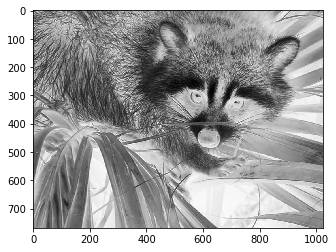

In [11]:
from scipy.misc import face
img_demo = face().astype(np.float32) / 255.

grads = tf.gradients(tf.reduce_sum((1 - img) ** 2), img)
with tf.Session() as sess:
    img_grads, = sess.run(grads, feed_dict={img: img_demo})
    
plt.imshow(np.sqrt(np.sum(img_grads ** 2, axis=2)), cmap="gray")

### Question:

   - Carry out the analytic differentiation of the function (1-img)^2 with respect to img, to confirm that the result is the same

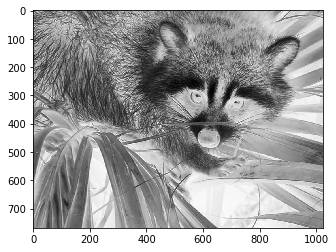

In [12]:
#TO CODE BY STUDENTS
#BEGIN STUDENT CODE
img_grads = 2*(img_demo-1)
#END STUDENT CODE
plt.imshow(np.sqrt(np.sum(img_grads ** 2, axis=2)), cmap="gray")

# MLP with TensorFlow

We are now going to create an MLP with tensorflow. We will start with an MLP with one hidden layer. The network should consist of the following operations, in the following order :

- Fully connected layer, with weights w1 and biases b1
- Sigmoid activation
- Fully connected layer, with weights w2 and biases b2
- Softmax output activation

We are going to be solving a multiclass classification problem, so the output of the network should be a probability distribution (thus the last softmax activation function).

The loss function should be defined as the cross-entropy between the predicted class and the true class.

We are going to use a gradient-based optimisation with batches. You will have to fetch the batches during training. 


First, we load the data.

C:\Users\User\Anaconda3\envs\tfenv\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


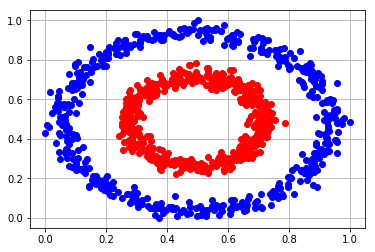

In [13]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)
# X, y = datasets.make_moons(n_samples=1000, random_state=42)  # try with 2 moons
X = MinMaxScaler().fit_transform(X)

# in order to convert y to a matrix with (num_examples, num_classes)
Y = tf.keras.utils.to_categorical(y)
Y[:10,:]

#show data in plot
plt.plot(X[y == 1, 0], X[y == 1, 1], 'ro')
plt.plot(X[y == 0, 0], X[y == 0, 1], 'bo')
plt.grid('on')

We are now going to define some useful auxillary functions.

First, a function that shows the decision boundary of our network. This works only for 2D input data

In [14]:
def plot_decision_function_2d(sess_in, Y_pred, X, Y):
   # create a mesh to plot in
    h = .02  # step size in the mesh
    offset = 0.1
    x_min, x_max = X[:, 0].min() - offset, X[:, 0].max() + offset
    y_min, y_max = X[:, 1].min() - offset, X[:, 1].max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = sess_in.run(Y_pred, feed_dict={X_input: np.c_[xx.ravel(), yy.ravel()]})
    #Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    if Z.ndim == 2:
        Z = np.argmax(Z, axis=1)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.plot(X[Y == 1, 0], X[Y == 1, 1], 'yo')
    plt.plot(X[Y == 0, 0], X[Y == 0, 1], 'ko')

    plt.title("Decision surface")
    plt.axis('tight')

Now, we need to define the functions that create the network. First, here are some useful Tensorflow functions

- tf.random_normal([n_input, n_hidden]) : creates a matrix containing random normal values, useful for weight initialisation, of size n_input-by-n_hidden
- tf.zeros([n]) : create a vector of size n filled with zeros, useful for initialising the biases
- tf.matmul(X, w_1) : fully connected layer with input X and weights w_1
- tf.nn.sigmoid(), tf.nn.softmax() : sigmoid and softmax non-linearities
- tf.train.GradientDescentOptimizer(), tf.train.AdamOptimizer : optimisation algorithms
- sess.run([tf_var_1, tf_var_2, ...], feed_dict={X: X_train, Y: Y_train}) : run the network on the Tensorflow variables tf_var_1 and tf_var_2 ...
    - If one of the tf_var_'s contains the output of tf.train.GradientDescentOptimizer() or tf.train.AdamOptimizer, then Tensorflow will carry out one step of training. The variables X and Y are defined as Tensorflow variables, and X_train and Y_train are the actual network input data
    
The network architecture is defined by concatenating a series of Tensorflow functions. For example :

output = tf.nn.sigmoid(tf.matmul(...))

would implement a simple fully connected layer followed by a non-linearity.

In [15]:
# TO C0DE BY STUDENTS

def init_weights_and_biases(shape, stddev=0.1, seed_in=None):
    """
    This function should return Tensorflow Variables containing the initialised weights and biases of the network,
    using a normal distribution for the initialisation, with stddev of the normal as an input argument
    
    Parameters
    ----------
    shape : tuple : (n_input_features,n_hidden,n_classes)
        shape of weights: 
    
    Returns
    -------
    w1, b1, w2, b2 : initialised weights and biases, with correct shapes
    """
    
    w1 = tf.Variable(tf.random_normal([shape[0],shape[1]], stddev=stddev,seed=seed_in))
    w2 = tf.Variable(tf.random_normal([shape[1],shape[2]], stddev=stddev,seed=seed_in))
    b1 = tf.Variable(tf.zeros([shape[1]]))
    b2 = tf.Variable(tf.zeros([shape[2]]))
    return w1, b1, w2, b2

def forward_prop(X, w1, b1, w2, b2):
    """
    This function should define the network architecture, explained above
    
    Parameters
    ----------
    X : input to network
    w1, w2 : Tensorflow Variables
        network weights
    b1, b2 : Tensorflow Variables
        network biases 
    
    Returns
    -------
    Y_pred :
    the output layer of the network, the classification prediction
    """
    
    # BEGIN STUDENT CODE
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, w1), b1))
    Y_pred = tf.nn.softmax(tf.add(tf.matmul(layer1, w2), b2))
    # END STUDENT CODE
    return Y_pred

In [17]:
# THIS CODE IS GIVEN

def accuracy(Y_pred, Y_true):
    """
    This function calculates the network's accuracy, ie the percentage of correct classifications.
    Here, we consider the class with the highest score in the network's output
    
    Parameters
    ----------
    Y_pred : Tensorfow variable
        predicted classification of network
    Y_true : Tensorfow variable
        true classes of input
    
    """
    
    acc = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y_true, 1))
    acc = tf.reduce_mean(tf.cast(acc, tf.float32))
    return acc
    
def plot_accuracy(train_accuracy,test_accuracy):
    """
    Helper function to plot accuracy
    
    Parameters
    ----------
    train_accuracy : python list
        training accuracy of network for different iterations
    test_accuracy : python list
        test accuracy of network for different iterations
    
    """
    
    plt.figure()
    plt.plot(train_accuracy, label='Train acc.')
    plt.plot(test_accuracy, label='Test acc.')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

We are now ready to create our network with a Tensorflow Session and to carry out training on our training dataset

(850, 2)
....................................................................................................

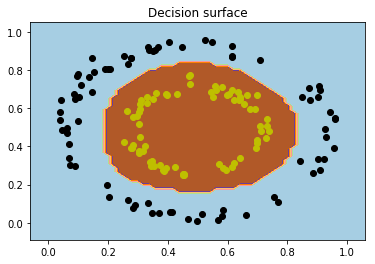

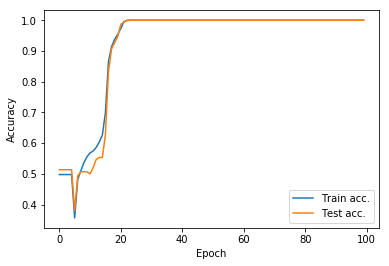

In [18]:
# We fix the random seed to make sure each training gives exactly the same results
RANDOM_SEED = 52#42
tf.set_random_seed(RANDOM_SEED)

#We now split up the data into training and test data, using a function from Scikit-learn :
X_train, X_test, Y_train, Y_test, y_train, y_test = \
    train_test_split(X, Y, y, test_size=0.15, random_state=RANDOM_SEED)
print(X_train.shape)

# Layer's sizes
n_input = X.shape[1]  # Number of input features
n_hidden = 50  # Number of hidden nodes
n_classes = Y.shape[1]  # Number of classes

# Placeholders for input and true output
X_input = tf.placeholder("float", shape=[None, n_input])
Y_true = tf.placeholder("float", shape=[None, n_classes])

# Weight initializations
stddev = 0.1
w1, b1, w2, b2 = init_weights_and_biases((n_input, n_hidden, n_classes), stddev, RANDOM_SEED)

#define network architecture
Y_pred = forward_prop(X_input, w1, b1, w2, b2)

#define cross entropy loss
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred),axis=1)

loss = tf.reduce_mean(cross_entropy)
acc = accuracy(Y_pred, Y_true)

#define the optimiser. We use the Adam algorithm here 
learning_rate = 0.01
training_variables = tf.train.AdamOptimizer(learning_rate).minimize(loss)

# Run optimisation algorithm
n_epochs = 100
train_accuracy = []
test_accuracy = []
batch_size = 10
n_batches = int(np.ceil(X_train.shape[0] / float(batch_size)))

# open Tensorflow session
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_idx in range(n_batches):
            # run a training step on the next batch of size batch_size
            batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            # BEGIN STUDENT CODE
            sess.run(training_variables, feed_dict={X_input: batch_x, Y_true: batch_y})
            #END STUDENT CODE
            
        # calculate accuracy for this epoch
        train_accuracy.append(sess.run(acc,  feed_dict={X_input: X_train,Y_true:Y_train}))
        test_accuracy.append(sess.run(acc,  feed_dict={X_input: X_test,Y_true:Y_test}))

        print(".", end='')
    #plot the decision surface of the trained network
    plot_decision_function_2d(sess,Y_pred,X_test,y_test)

    sess.close()

    #plot the accuracy
    plot_accuracy(train_accuracy,test_accuracy)


# MLP with several hidden layers

We are now going to create an MLP with several hidden layers. We are going to implement the following architecture :

- Fully connected layer, with weights w1 and biases b1
- Sigmoid activation
- Fully connected layer, with weights w2 and biases b2
- Sigmoid activation
- Fully connected layer, with weights w3 and biases b3
- Softmax output activation

We are also going to use a more complicated dataset : the MNIST dataset, which contains images of handwritten digits. There are 10 classes, one for each digit.

First, we load the MNIST dataset.

In [28]:
# Import MNIST data
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

Y_train = tf.keras.utils.to_categorical(y_train)  # in order to convert y to a matrix with (num_examples, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test)  # in order to convert y to a matrix with (num_examples, num_classes)

#reshape the input images : flatten the last two dimensions
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1]*X_test.shape[2]))


Now, redefine the weight and architecture functions to redfine the network

In [29]:
# TO C0DE BY STUDENTS

def init_weights_and_biases(shape, stddev=0.1, seed_in=None):
    """
    This function should return Tensorflow Variables containing the initialised weights and biases of the network,
    using a normal distribution for the initialisation, with stddev of the normal as an input argument
    
    Parameters
    ----------
    shape : tuple, (n_input_features, n_hidden_1, n_hidden_2, n_classes)
        sizes necessary for defining the weights and biases
    
    Returns
    -------
    w1, b1, w2, b2, w3, b3: initialised weights and biases, with correct shapes
    """
    
    # BEGIN STUDENT CODE
    w1 = tf.Variable(tf.random_normal([shape[0], shape[1]], seed=seed_in))
    w2 = tf.Variable(tf.random_normal([shape[1], shape[2]], seed=seed_in))
    w3 = tf.Variable(tf.random_normal([shape[2], shape[3]], seed=seed_in))
    b1 = tf.Variable(tf.zeros([shape[1]]))
    b2 = tf.Variable(tf.zeros([shape[2]]))
    b3 = tf.Variable(tf.zeros([shape[3]]))
    # END STUDENT CODE
    return w1, b1, w2, b2, w3, b3

def forward_prop_multi_layer(X, w1, b1, w2, b2, w3, b3):
    """
    This function should define the network architecture, explained above
    
    Parameters
    ----------
    X : input to network
    w1, w2, w3 : Tensorflow Variables
        network weights
    b1, b2, b3 : Tensorflow Variables
        network biases 
    
    Returns
    -------
    Y_pred :
    the output layer of the network, the classification prediction
    """
    
    # BEGIN STUDENT CODE
    layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, w1), b1))
    layer2 = tf.nn.sigmoid(tf.add(tf.matmul(layer1, w2), b2))
    Y_pred = tf.nn.softmax(tf.add(tf.matmul(layer2, w3), b3))
    # END STUDENT CODE
    return Y_pred

Finally, fill in the following code to create and train your MLP

600
....................Training finished


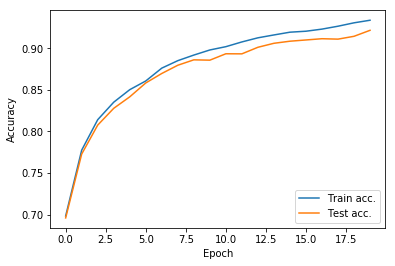

In [32]:
RANDOM_SEED = 52#42#
tf.set_random_seed(RANDOM_SEED)

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# tf Graph input
X_input = tf.placeholder("float", [None, n_input])
Y_true = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
stddev = 0.1

w1,b1,w2,b2,w3,b3 = init_weights_and_biases([n_input, n_hidden_1, n_hidden_2,n_classes], stddev=0.1, seed_in=RANDOM_SEED)

# Construct model
Y_pred = forward_prop_multi_layer(X_input,w1,b1,w2,b2,w3,b3)

# Define loss and optimizer
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred),axis=1)

loss = tf.reduce_mean(cross_entropy)
acc = accuracy(Y_pred, Y_true)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_variables = optimizer.minimize(loss)

# Parameters
n_epochs = 20
train_accuracy = []
test_accuracy = []
batch_size = 100
display_step = 1
n_batches = int(np.ceil(X_train.shape[0]/batch_size))
print(n_batches)

with tf.Session() as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        # Loop over all batches
        for batch_idx in range(n_batches):
            #idx = np.random.randint(0, len(X_train), batch_size)
            #get the next batch in the MNIST dataset and carry out training
            batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            #BEGIN STUDENT CODE
            sess.run(training_variables, feed_dict={X_input: batch_x, Y_true: batch_y})
            #END STUDENT CODE
            
        # calculate accuracy for this epoch
        train_accuracy.append(sess.run(acc, feed_dict={X_input: X_train,Y_true:Y_train}))
        test_accuracy.append(sess.run(acc,  feed_dict={X_input: X_test,Y_true:Y_test}))
            
        print(".", end='')
print("Training finished")

#plot the accuracy
plot_accuracy(train_accuracy,test_accuracy)

## Regularisation

We are now going to try several regularisation techniques, to improve classification results.

### Weight regularisation

The simplest is called weight decay. This adds the sum of the squared values of the network weights to the loss. The interplay between the cross entropy and the weight decay should be controlled via a scalar, which we refer to as beta.

The l2 norm of a the weights in a variable w1 can be calculated with the following Tensorflow function :

tf.nn.l2_loss(w1)

Implement this loss and combine it with the cross entropy loss, with a weighting scalar beta

600
....................Training finished


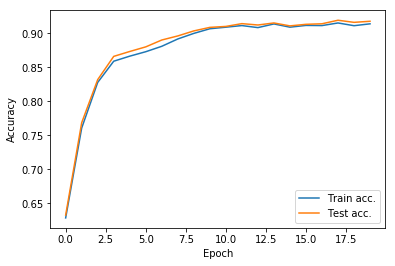

In [31]:
# ALL OF THIS CAN BE RECODED BY THE STUDENTS

RANDOM_SEED = 52#42#
tf.set_random_seed(RANDOM_SEED)

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# tf Graph input
X_input = tf.placeholder("float", [None, n_input])
Y_true = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
stddev = 0.1

w1,b1,w2,b2,w3,b3 = init_weights_and_biases([n_input, n_hidden_1, n_hidden_2,n_classes], stddev=0.1, seed_in=RANDOM_SEED)

# Construct model
Y_pred = forward_prop_multi_layer(X_input,w1,b1,w2,b2,w3,b3)

# Define loss, regularisation and optimizer
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred),axis=1)
beta = 0.01
#BEGIN STUDENT CODE
regularizer = tf.nn.l2_loss(w1) + tf.nn.l2_loss(w2) + tf.nn.l2_loss(w3)
loss = cross_entropy + beta*regularizer
#END STUDENT CODE

acc = accuracy(Y_pred, Y_true)

learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_variables = optimizer.minimize(loss)

# Parameters
n_epochs = 20
train_accuracy = []
test_accuracy = []
batch_size = 100
display_step = 1
n_batches = int(np.ceil(X_train.shape[0]/batch_size))
print(n_batches)

with tf.Session() as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        # Loop over all batches
        for batch_idx in range(n_batches):
            #get the next batch in the MNIST dataset and carry out training
            batch_x = X_train[(batch_idx)*batch_size:(batch_idx+1)*batch_size]
            batch_y = Y_train[(batch_idx)*batch_size:(batch_idx+1)*batch_size]
            #BEGIN STUDENT CODE
            # Run training step
            sess.run(training_variables, feed_dict={X_input: batch_x, Y_true: batch_y})
            #END STUDENT CODE
        # calculate accuracy for this epoch
        train_accuracy.append(sess.run(acc, feed_dict={X_input: X_train,Y_true:Y_train}))
        test_accuracy.append(sess.run(acc,  feed_dict={X_input: X_test,Y_true:Y_test}))
            
        print(".", end='')
print("Training finished")

#plot the accuracy
plot_accuracy(train_accuracy,test_accuracy)

Question : what happens to the training and test accuracies ? How do you explain this ?

We see that the results are similar (in our case, approximately $0.92$ of accuracy without regularization, $0.9$ with $L^{2}$ regularization). Besides, we remark that when we add regularization, the test accuracy is higher than the training accuracy (training accuracy was always higher than the test accuracy without regularization), which may be a sign that the model generalizes better. Large weights in a neural network are an indication that the model has overfit the training set, that is why we prefer small values for the weights, to generalize better.

### Dropout

Another type of normalisation is called 'dropout'. This randomly cuts (disconnects) certain connections in the network. This can be done quite easily in Tensorflow, by using the following Tensorflow function :

tf.nn.dropout(layer, alpha),

where alpha is a scalar that controls the probability of a connection being kept (not cut).

Implement dropout in the architecture function (forward_prop_multi_layer) and look at the training loss. 

In [35]:
#TO CODE BY STUDENTS

# PARAMETERS :
# x : input vector
# w1,w2,w3 : weights
# alpha : probability of keeping connexion
def forward_prop_multi_layer_reg(x,w1,b1,w2,b2,w3,b3,alpha):
    # BEGIN STUDENT CODE
    layer1 = tf.nn.dropout(tf.nn.sigmoid(tf.add(tf.matmul(x, w1), b1)), alpha)
    layer2 = tf.nn.dropout(tf.nn.sigmoid(tf.add(tf.matmul(layer1, w2), b2)), alpha)
    Y_pred = tf.nn.softmax(tf.add(tf.matmul(layer2, w3), b3))
    #END STUDENT CODE
    return Y_pred

600
....................Training finished


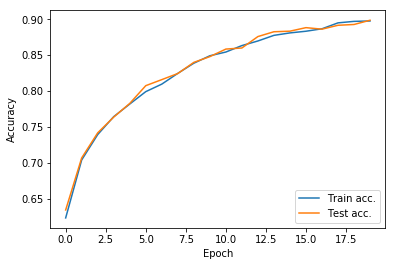

In [41]:
RANDOM_SEED = 52#42#
tf.set_random_seed(RANDOM_SEED)

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# tf Graph input
X_input = tf.placeholder("float", [None, n_input])
Y_true = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
stddev = 0.1

w1,b1,w2,b2,w3,b3 = init_weights_and_biases([n_input, n_hidden_1, n_hidden_2, n_classes], stddev=0.1, seed_in=RANDOM_SEED)

# Construct model
alpha=0.85
Y_pred = forward_prop_multi_layer_reg(X_input,w1,b1,w2,b2,w3,b3,alpha)

# Define loss and optimizer
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred),axis=1)

loss = tf.reduce_mean(cross_entropy)
acc = accuracy(Y_pred, Y_true)

learning_rate = 0.002
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_variables = optimizer.minimize(loss)

# Parameters
n_epochs = 20
train_accuracy = []
test_accuracy = []
batch_size = 100
display_step = 1
n_batches = int(np.ceil(X_train.shape[0]/batch_size))
print(n_batches)

with tf.Session() as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        # Loop over all batches
        for batch_idx in range(n_batches):
            #get the next batch in the MNIST dataset and carry out training
            batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            #BEGIN STUDENT CODE
            sess.run(training_variables, feed_dict={X_input: batch_x, Y_true: batch_y})
            #END STUDENT CODE
            
        # calculate accuracy for this epoch
        train_accuracy.append(sess.run(acc, feed_dict={X_input: X_train,Y_true:Y_train}))
        test_accuracy.append(sess.run(acc,  feed_dict={X_input: X_test,Y_true:Y_test}))
            
        print(".", end='')
print("Training finished")

#plot the accuracy
plot_accuracy(train_accuracy,test_accuracy)

## BATCH NORMALISATION

Another approach to regularisation which we have seen during the lesson is known as batch normalisation.

Implement this in your network. You can retrieve the necessary moments of the network layers with :

tf.nn.moments(...)

Redefine the architecture function ('forward_prop_multi_layer') to implement batch normalisation

In [70]:
#TO CODE BY STUDENTS

# PARAMETERS :
# x : input vector
# w1,w2,w3 : weights
def forward_prop_multi_layer_batch_norm(x, w1, b1, w2, b2, w3, b3):
    epsilon = 1e-5 #to avoid dividing by zero
    # BEGIN STUDENT CODE
    
    # Layer 1 with batch normalization
    z1_BN = tf.add(tf.matmul(x, w1), b1)
    
    # Compute batch mean and variance
    batch_mean1, batch_var1 = tf.nn.moments(z1_BN,[0])
    
    # Apply the initial batch normalizing transform
    z1_norm = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)

    # Create two new parameters, scale and beta (shift)
    gamma1 = tf.Variable(tf.ones([z1_norm.shape[1]]))
    beta1 = tf.Variable(tf.zeros([z1_norm.shape[1]]))
    
    # Scale and shift to obtain the final output of the batch normalization
    # this value is fed into the activation function (here a sigmoid)
    BN1 = gamma1 * z1_norm + beta1
    layer1_BN = tf.nn.sigmoid(BN1)
    
    
    # Layer 2 with batch normalization
    z2_BN = tf.add(tf.matmul(layer1_BN, w2), b2)
    
    batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
    z2_norm = (z2_BN - batch_mean2) / tf.sqrt(batch_var2 + epsilon)

    gamma2 = tf.Variable(tf.ones([z2_norm.shape[1]]))
    beta2 = tf.Variable(tf.zeros([z2_norm.shape[1]]))

    BN2 = gamma2 * z2_norm + beta2
    layer2_BN = tf.nn.sigmoid(BN2)
    
    # Prediction
    Y_pred = tf.nn.softmax(tf.add(tf.matmul(layer2_BN, w3), b3))
    return Y_pred
    #END STUDENT CODE

(?, 256)
(?, 256)
600
....................Training finished


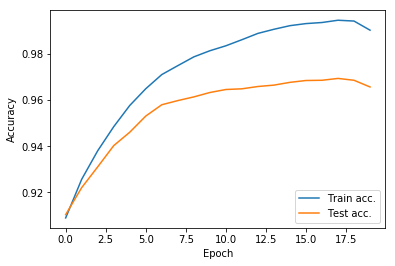

In [71]:
# YOU CAN USE THE PREVIOUS CODE
RANDOM_SEED = 52#42#
tf.set_random_seed(RANDOM_SEED)

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_input = X_train.shape[1]
n_classes = Y_train.shape[1] # MNIST total classes (0-9 digits)

# tf Graph input
X_input = tf.placeholder("float", [None, n_input])
Y_true = tf.placeholder("float", [None, n_classes])

# Store layers weight & bias
stddev = 0.1

w1,b1,w2,b2,w3,b3 = init_weights_and_biases([n_input, n_hidden_1, n_hidden_2, n_classes], stddev=0.1, seed_in=RANDOM_SEED)

# Construct model
Y_pred = forward_prop_multi_layer_batch_norm(X_input,w1,b1,w2,b2,w3,b3)

# Define loss and optimizer
cross_entropy = -tf.reduce_sum(Y_true * tf.log(Y_pred),axis=1)

loss = tf.reduce_mean(cross_entropy)
acc = accuracy(Y_pred, Y_true)

learning_rate = 0.002
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_variables = optimizer.minimize(loss)

# Parameters
n_epochs = 20
train_accuracy = []
test_accuracy = []
batch_size = 100
display_step = 1
n_batches = int(np.ceil(X_train.shape[0]/batch_size))
print(n_batches)

with tf.Session() as sess:
    # Initializing the variables
    init = tf.global_variables_initializer()
    sess.run(init)

    for epoch in range(n_epochs):
        # Loop over all batches
        for batch_idx in range(n_batches):
            #get the next batch in the MNIST dataset and carry out training
            batch_x = X_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            batch_y = Y_train[batch_idx*batch_size:(batch_idx+1)*batch_size]
            #BEGIN STUDENT CODE
            sess.run(training_variables, feed_dict={X_input: batch_x, Y_true: batch_y})
            #END STUDENT CODE
            
        # calculate accuracy for this epoch
        train_accuracy.append(sess.run(acc, feed_dict={X_input: X_train,Y_true:Y_train}))
        test_accuracy.append(sess.run(acc,  feed_dict={X_input: X_test,Y_true:Y_test}))
            
        print(".", end='')
print("Training finished")

#plot the accuracy
plot_accuracy(train_accuracy,test_accuracy)

#### Documentation:

  - http://www.tensorflow.org
  - http://www.deeplearningbook.org/